### Libraries

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier
import optuna

In [32]:
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [33]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [34]:
# check that all rows were in the joined dataset
len(df) == len(train_label) == len(train_values)

True

In [35]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [36]:
# search for duplicates 
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [37]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['column', 'number of missing values']
missing[missing['number of missing values']>0]

,column,number of missing values
3,funder,3637
5,installer,3655
8,wpt_name,2
11,subvillage,371
18,public_meeting,3334
20,scheme_management,3878
21,scheme_name,28810
22,permit,3056


### Remove Unwanted Fields

In [38]:
# uneeded columns (fields that don't help predict the target label)
unneeded_col = ['id', 'recorded_by', 'wpt_name']
df = df.drop(unneeded_col, axis=1)



### Handling Fields with Too Many Unique Values

In [46]:
# get all categorical variables
df['region_code'] = df['region_code'].astype('object')
df['district_code'] = df['district_code'].astype('object')

cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count_df = pd.DataFrame(col_count.items())
col_count_df.columns = ['Field', 'Number of Unique Values']
col_count_df.head()

,Field,Number of Unique Values
0,date_recorded,356
1,funder,1896
2,installer,2145
3,basin,9
4,subvillage,19287


In [47]:
# redundant data (fields with information provided in other columns)
redundant_col = ['subvillage','latitude', 'longitude', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'waterpoint_type']

df = df.drop(redundant_col, axis=1)

### Handle Fields with Missing Values

In [49]:
cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count

{'date_recorded': 356,
 'funder': 1896,
 'installer': 2145,
 'basin': 9,
 'region': 21,
 'public_meeting': 2,
 'scheme_management': 11,
 'permit': 2,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_class': 3,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [50]:
missing = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
missing.columns = ['column', '% missing values']
missing[missing['% missing values']>0]

,column,% missing values
2,funder,6.122896
4,installer,6.153199
9,public_meeting,5.612795
10,scheme_management,6.528620
11,permit,5.144781


### Handle Date Values

In [51]:
# derive age of water pump (i.e., years since construction)
df['construction_year'] = pd.to_datetime(df['construction_year'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['age'] = (df['date_recorded'] - df['construction_year']) / np.timedelta64(1, 'Y')

# delete construction_year and date_recorded columns 
df = df.drop(['construction_year', 'date_recorded'], axis=1)

In [52]:
# get quantifiable variables
num_var = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_var

['amount_tsh', 'gps_height', 'num_private', 'population', 'age']

### Testing Numerical Features With ANOVA

In [53]:
df.isnull().sum()

amount_tsh                  0
funder                   3637
gps_height                  0
installer                3655
num_private                 0
basin                       0
region                      0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
extraction_type_class       0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
status_group                0
age                         0
dtype: int64

<Axes: >

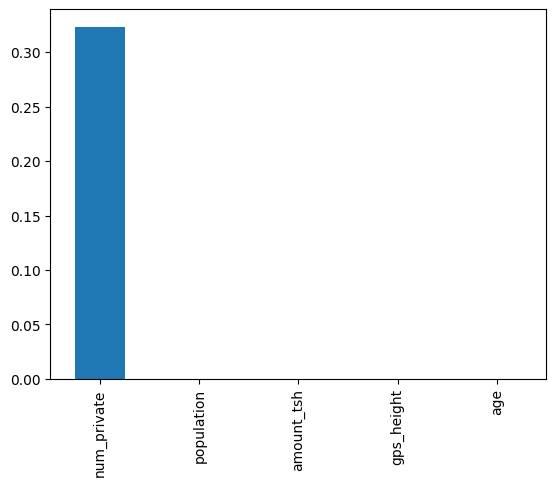

In [54]:
# copy the dataset for ANOVA test
df_int = df.copy(deep=True)

# keep the numerical columns and the target label
int_var = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']] + ['status_group']
df_int = df_int[int_var]

# get the input and output variables
X = df_int.drop('status_group', axis=1)
y = df_int['status_group']

# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(X, y)

# compute the p-values for each F-statistic
p_values = {col: np.round(p_value, 4) for col, p_value in zip(X.columns, fit.pvalues_)}

p_values = pd.Series(p_values.values(),index = p_values.keys())
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [55]:
# columns with high p-values from ANOVA test
anova_drop = ['num_private']
df = df.drop(anova_drop, axis=1)

### Testing Categorical Features With Chi-Square Test

In [56]:
# copy the dataframe for chi square tests
df_chi = df.copy(deep=True)

# keep the categorical variables in the data frame
cat_var = [col for col in df_chi.columns if df[col].dtypes == 'object']
df_chi = df_chi[cat_var]

# encode the categorical variables
label_encoder = LabelEncoder()
for col in df_chi.columns:
    df_chi[col] = label_encoder.fit_transform(df_chi[col])

# get input and output variables
X = df_chi.drop('status_group',axis=1)
y = df_chi['status_group']

# perform chi-square tests
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


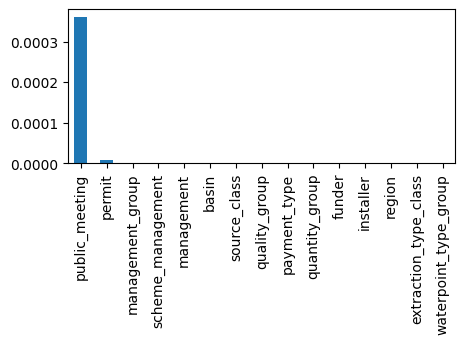

In [57]:
plt.figure(figsize=(5,2))
p_values.plot.bar()
plt.show()


In [58]:
df.shape

(59400, 20)

In [59]:
df.head(3)

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,status_group,age
0,6000.0,Roman,1390,Roman,Lake Nyasa,Iringa,109,True,VWC,False,gravity,vwc,user-group,annually,good,enough,groundwater,communal standpipe,functional,41.224658
1,0.0,Grumeti,1399,GRUMETI,Lake Victoria,Mara,280,NaN,Other,True,gravity,wug,user-group,never pay,good,insufficient,surface,communal standpipe,functional,43.205479
2,25.0,Lottery Club,686,World vision,Pangani,Manyara,250,True,VWC,True,gravity,vwc,user-group,per bucket,good,enough,surface,communal standpipe,functional,43.180822


In [63]:
df.isnull().sum()

amount_tsh                  0
funder                   3637
gps_height                  0
installer                3655
basin                       0
region                      0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
extraction_type_class       0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
status_group                0
age                         0
dtype: int64

In [64]:
# Find the columns with boolean values
bool_cols = df.select_dtypes(include='bool').columns.tolist()

# Print the list of boolean columns
print(bool_cols)

[]


In [67]:
# convert boolean to str 
cat_var = [col for col in df.columns if df[col].dtypes=='object']
for col in cat_var:
    df[col] = df[col].astype(str)

In [68]:
df.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
basin                    0
region                   0
population               0
public_meeting           0
scheme_management        0
permit                   0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_class             0
waterpoint_type_group    0
status_group             0
age                      0
dtype: int64

### Baseline Models

In [24]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [26]:
X_train.isnull().sum()

amount_tsh                  0
funder                   2548
gps_height                  0
installer                2555
basin                       0
region                      0
population                  0
public_meeting           2297
scheme_management        2733
permit                   2151
extraction_type_class       0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
age                         0
dtype: int64

In [27]:
# encode the target label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [28]:
# train a dummy classifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

In [29]:
# Define the column transformer
cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']

# perform one hot encoding on the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat_var)  # one hot encoding of categorical variables
    ], remainder='passthrough')

pipeline_log = Pipeline(steps=[('drop_na', SimpleImputer(strategy='constant', fill_value='drop')),
                           ('one_hot', preprocessor),
                           ('log_reg', LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42))])
pipeline_log.fit(X_train, y_train)

y_pred_log = pipeline_log.predict(X_test)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['bool', 'str']

In [215]:
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
f2_score_log = fbeta_score(y_test, y_pred_log, average='micro', beta=2)

print(f'F2 score of dummy classifier: {f2_score_dummy}')
print(f'F2 score of logistic regression classifier: {f2_score_log}')

F2 score of dummy classifier: 0.32895622895622895
F2 score of logistic regression classifier: 0.6843434343434344


In [216]:
X_train.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
basin                    0
region                   0
population               0
public_meeting           0
scheme_management        0
permit                   0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_class             0
waterpoint_type_group    0
age                      0
dtype: int64

### CatBoost Model

In [183]:

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10)
    }

    # perform one hot encoding on the categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat_var)  # one hot encoding of categorical variables
        ], remainder='passthrough')


    
    # Define the pipeline with SimpleImputer and CatBoostClassifier
    pipeline = Pipeline([
        ('drop_na', SimpleImputer(strategy='constant', fill_value='drop')),
        ('preprocess', preprocessor),
        ('catboost', CatBoostClassifier(**params))
    ])
        
    # Perform cross-validation with the pipeline and return the F2 score
    score = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1_micro').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-04-30 18:23:14,052] A new study created in memory with name: no-name-c46a23b4-f913-4078-b92f-3ce7feedef56
C:\Users\aashi\AppData\Local\Temp\ipykernel_20764\530688981.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),


0:	learn: 1.0412648	total: 316ms	remaining: 1m 34s
1:	learn: 0.9935921	total: 661ms	remaining: 1m 38s
2:	learn: 0.9532217	total: 1.03s	remaining: 1m 41s
3:	learn: 0.9187942	total: 1.28s	remaining: 1m 34s
4:	learn: 0.8896600	total: 1.53s	remaining: 1m 30s
5:	learn: 0.8636332	total: 1.77s	remaining: 1m 26s
6:	learn: 0.8402616	total: 2s	remaining: 1m 23s
7:	learn: 0.8216290	total: 2.26s	remaining: 1m 22s
8:	learn: 0.8042131	total: 2.52s	remaining: 1m 21s
9:	learn: 0.7878242	total: 2.75s	remaining: 1m 19s
10:	learn: 0.7726865	total: 3.02s	remaining: 1m 19s
11:	learn: 0.7590401	total: 3.29s	remaining: 1m 18s
12:	learn: 0.7464263	total: 3.53s	remaining: 1m 18s
13:	learn: 0.7347759	total: 3.77s	remaining: 1m 17s
14:	learn: 0.7257821	total: 4s	remaining: 1m 15s
15:	learn: 0.7175497	total: 4.23s	remaining: 1m 15s
16:	learn: 0.7089232	total: 4.46s	remaining: 1m 14s
17:	learn: 0.7011080	total: 4.7s	remaining: 1m 13s
18:	learn: 0.6942720	total: 4.97s	remaining: 1m 13s
19:	learn: 0.6882768	total: 5

[I 2023-04-30 18:27:17,475] Trial 0 finished with value: 0.7702741702741703 and parameters: {'learning_rate': 0.08171622556096499, 'iterations': 300, 'depth': 10}. Best is trial 0 with value: 0.7702741702741703.
C:\Users\aashi\AppData\Local\Temp\ipykernel_20764\530688981.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),


0:	learn: 1.0572853	total: 26.8ms	remaining: 13.4s
1:	learn: 1.0217641	total: 49.3ms	remaining: 12.3s
2:	learn: 0.9910534	total: 71.1ms	remaining: 11.8s
3:	learn: 0.9635567	total: 92.7ms	remaining: 11.5s
4:	learn: 0.9385985	total: 114ms	remaining: 11.3s
5:	learn: 0.9168532	total: 137ms	remaining: 11.2s
6:	learn: 0.8974202	total: 159ms	remaining: 11.2s
7:	learn: 0.8795000	total: 181ms	remaining: 11.1s
8:	learn: 0.8637231	total: 202ms	remaining: 11s
9:	learn: 0.8488602	total: 224ms	remaining: 11s
10:	learn: 0.8360230	total: 249ms	remaining: 11s
11:	learn: 0.8236628	total: 278ms	remaining: 11.3s
12:	learn: 0.8128786	total: 307ms	remaining: 11.5s
13:	learn: 0.8033232	total: 335ms	remaining: 11.6s
14:	learn: 0.7940876	total: 364ms	remaining: 11.8s
15:	learn: 0.7855723	total: 398ms	remaining: 12.1s
16:	learn: 0.7780203	total: 440ms	remaining: 12.5s
17:	learn: 0.7705654	total: 474ms	remaining: 12.7s
18:	learn: 0.7637136	total: 507ms	remaining: 12.8s
19:	learn: 0.7582306	total: 538ms	remaining

[I 2023-04-30 18:28:04,408] Trial 1 finished with value: 0.7551948051948051 and parameters: {'learning_rate': 0.060601554098945166, 'iterations': 500, 'depth': 6}. Best is trial 0 with value: 0.7702741702741703.
C:\Users\aashi\AppData\Local\Temp\ipykernel_20764\530688981.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),


0:	learn: 1.0364540	total: 66.2ms	remaining: 19.8s
1:	learn: 0.9856027	total: 134ms	remaining: 20s
2:	learn: 0.9449750	total: 205ms	remaining: 20.2s
3:	learn: 0.9093120	total: 267ms	remaining: 19.8s
4:	learn: 0.8790577	total: 330ms	remaining: 19.5s
5:	learn: 0.8533084	total: 402ms	remaining: 19.7s
6:	learn: 0.8314943	total: 516ms	remaining: 21.6s
7:	learn: 0.8115071	total: 630ms	remaining: 23s
8:	learn: 0.7944558	total: 706ms	remaining: 22.8s
9:	learn: 0.7792284	total: 775ms	remaining: 22.5s
10:	learn: 0.7663865	total: 874ms	remaining: 23s
11:	learn: 0.7551585	total: 954ms	remaining: 22.9s
12:	learn: 0.7449117	total: 1.03s	remaining: 22.7s
13:	learn: 0.7359099	total: 1.09s	remaining: 22.3s
14:	learn: 0.7270053	total: 1.16s	remaining: 22s
15:	learn: 0.7200367	total: 1.22s	remaining: 21.7s
16:	learn: 0.7119128	total: 1.28s	remaining: 21.4s
17:	learn: 0.7063125	total: 1.35s	remaining: 21.2s
18:	learn: 0.7012999	total: 1.42s	remaining: 21s
19:	learn: 0.6967109	total: 1.49s	remaining: 20.8s

[I 2023-04-30 18:29:10,208] Trial 2 finished with value: 0.7635882635882636 and parameters: {'learning_rate': 0.0910457823173142, 'iterations': 300, 'depth': 8}. Best is trial 0 with value: 0.7702741702741703.


299:	learn: 0.5499983	total: 21.1s	remaining: 0us


C:\Users\aashi\AppData\Local\Temp\ipykernel_20764\530688981.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),


0:	learn: 1.0908698	total: 17.1ms	remaining: 15.4s
1:	learn: 1.0834822	total: 27.9ms	remaining: 12.5s
2:	learn: 1.0761209	total: 38.8ms	remaining: 11.6s
3:	learn: 1.0689223	total: 49.3ms	remaining: 11s
4:	learn: 1.0619346	total: 67.1ms	remaining: 12s
5:	learn: 1.0550505	total: 78.1ms	remaining: 11.6s
6:	learn: 1.0484642	total: 94.5ms	remaining: 12s
7:	learn: 1.0419949	total: 106ms	remaining: 11.8s
8:	learn: 1.0357838	total: 117ms	remaining: 11.6s
9:	learn: 1.0296135	total: 127ms	remaining: 11.3s
10:	learn: 1.0236264	total: 144ms	remaining: 11.7s
11:	learn: 1.0177723	total: 156ms	remaining: 11.6s
12:	learn: 1.0119965	total: 172ms	remaining: 11.7s
13:	learn: 1.0064342	total: 186ms	remaining: 11.8s
14:	learn: 1.0010591	total: 198ms	remaining: 11.7s
15:	learn: 0.9957763	total: 208ms	remaining: 11.5s
16:	learn: 0.9904706	total: 225ms	remaining: 11.7s
17:	learn: 0.9853699	total: 237ms	remaining: 11.6s
18:	learn: 0.9802873	total: 251ms	remaining: 11.6s
19:	learn: 0.9755194	total: 265ms	remain

[I 2023-04-30 18:29:48,702] Trial 3 finished with value: 0.7341269841269842 and parameters: {'learning_rate': 0.011351260787493258, 'iterations': 900, 'depth': 4}. Best is trial 0 with value: 0.7702741702741703.
C:\Users\aashi\AppData\Local\Temp\ipykernel_20764\530688981.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),


0:	learn: 1.0369651	total: 20.6ms	remaining: 20.6s
1:	learn: 0.9879604	total: 46.2ms	remaining: 23s
2:	learn: 0.9482734	total: 86.4ms	remaining: 28.7s
3:	learn: 0.9143512	total: 108ms	remaining: 26.9s
4:	learn: 0.8851991	total: 137ms	remaining: 27.2s
5:	learn: 0.8609884	total: 164ms	remaining: 27.2s
6:	learn: 0.8393841	total: 188ms	remaining: 26.7s
7:	learn: 0.8210612	total: 228ms	remaining: 28.3s
8:	learn: 0.8054335	total: 273ms	remaining: 30s
9:	learn: 0.7914588	total: 314ms	remaining: 31.1s
10:	learn: 0.7799533	total: 353ms	remaining: 31.7s
11:	learn: 0.7685396	total: 391ms	remaining: 32.2s
12:	learn: 0.7582981	total: 433ms	remaining: 32.9s
13:	learn: 0.7497313	total: 478ms	remaining: 33.7s
14:	learn: 0.7425834	total: 517ms	remaining: 34s
15:	learn: 0.7354223	total: 554ms	remaining: 34.1s
16:	learn: 0.7294690	total: 588ms	remaining: 34s
17:	learn: 0.7232873	total: 618ms	remaining: 33.7s
18:	learn: 0.7174995	total: 652ms	remaining: 33.6s
19:	learn: 0.7134617	total: 682ms	remaining: 3

[I 2023-04-30 18:31:11,215] Trial 4 finished with value: 0.7678451178451179 and parameters: {'learning_rate': 0.09189463383798988, 'iterations': 1000, 'depth': 6}. Best is trial 0 with value: 0.7702741702741703.


998:	learn: 0.5399440	total: 25.3s	remaining: 25.3ms
999:	learn: 0.5399361	total: 25.3s	remaining: 0us


In [185]:
best_params = study.best_params
# perform one hot encoding on the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat_var)  # one hot encoding of categorical variables
    ], remainder='passthrough')



# Define the pipeline with SimpleImputer and CatBoostClassifier
pipeline_cbc = Pipeline([
    ('drop_na', SimpleImputer(strategy='constant', fill_value='drop')),
    ('preprocess', preprocessor),
    ('catboost', CatBoostClassifier(**best_params, verbose=False))
])
pipeline_cbc.fit(X_train, y_train)
y_pred_cbc= pipeline_cbc.predict(X_test)

0:	learn: 1.0392512	total: 379ms	remaining: 1m 53s
1:	learn: 0.9921837	total: 651ms	remaining: 1m 37s
2:	learn: 0.9517576	total: 962ms	remaining: 1m 35s
3:	learn: 0.9157350	total: 1.29s	remaining: 1m 35s
4:	learn: 0.8871972	total: 1.63s	remaining: 1m 36s
5:	learn: 0.8605048	total: 1.92s	remaining: 1m 33s
6:	learn: 0.8375131	total: 2.19s	remaining: 1m 31s
7:	learn: 0.8170645	total: 2.52s	remaining: 1m 32s
8:	learn: 0.7991953	total: 2.78s	remaining: 1m 29s
9:	learn: 0.7826132	total: 3.06s	remaining: 1m 28s
10:	learn: 0.7677970	total: 3.33s	remaining: 1m 27s
11:	learn: 0.7553880	total: 3.59s	remaining: 1m 26s
12:	learn: 0.7429695	total: 3.86s	remaining: 1m 25s
13:	learn: 0.7325526	total: 4.19s	remaining: 1m 25s
14:	learn: 0.7235804	total: 4.44s	remaining: 1m 24s
15:	learn: 0.7144155	total: 4.7s	remaining: 1m 23s
16:	learn: 0.7078363	total: 4.94s	remaining: 1m 22s
17:	learn: 0.7010888	total: 5.21s	remaining: 1m 21s
18:	learn: 0.6948211	total: 5.51s	remaining: 1m 21s
19:	learn: 0.6889052	to

In [188]:
f2_score_cbc = fbeta_score(y_test, y_pred_cbc, beta=2, average='micro')
f2_score_cbc

0.7762626262626262

1. lack of understanding of variables (hard to address many unique values)
2. Lack of information on business constraints (cost of repairing/replacing a water pump)